In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import scipy 
from tqdm import tqdm
import matplotlib.dates as mdates
import EoN
import networkx as nx
import random
import matplotlib.dates as mdates
import locale
locale.setlocale(locale.LC_TIME, 'ru_RU.UTF-8')

from model_complex.compartmental_models import Calibration, EpidData, FactoryModel
from model_complex.compartmental_models.models.Models.ModelParams import ModelParams

In [7]:
def plot_calibration_result(simulation_data, observed_data, title=''):
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    ax.plot(simulation_data, label='simulation', color='royalblue')
    ax.plot(observed_data, "--o", label='data', color='orangered')
    ax.set_xlabel('Weeks')
    ax.set_ylabel('Incidence, cases')
    min_len = min(len(simulation_data), len(observed_data))
    ax.text(1, 1000, f'$R^2={round(r2_score(simulation_data[:min_len], observed_data[:min_len]), 2)}$')
    ax.set_title(title)
    ax.legend()
    plt.show()

### Calibration using approximate bayes computation

##### Total regime

In [8]:
epid_data = EpidData(city='spb', path='./', 
                start_time='01-07-2014', end_time='20-08-2015')
data_df = epid_data.get_wave_data(regime='total')
prepared_data = epid_data.prepare_for_calibration()
init_infected = [100]
model = FactoryModel.total()

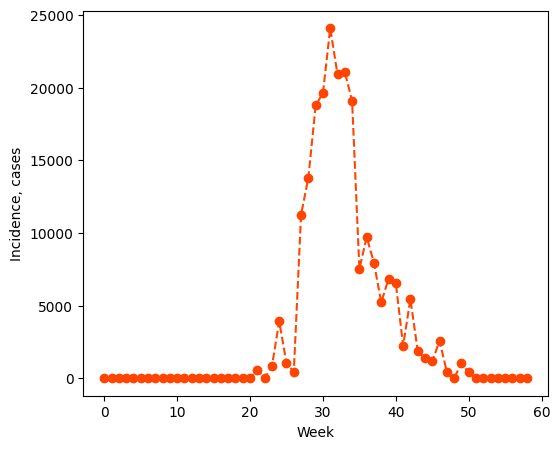

In [9]:
size = len(prepared_data)
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.set_xlabel('Week')
ax.set_ylabel('Incidence, cases')
ax.plot(prepared_data[0:size], "--o", color='orangered')

In [10]:
rho = int(data_df['total_population'].iloc[0])/10
model_params = model_params = ModelParams(alpha=[0.7], beta=[0.6], initial_infectious=[100], population_size=rho)
d = Calibration(model=model, data=prepared_data, model_params=model_params)
alpha, beta = d.abc_calibration()

Initializing SMC sampler...
Sampling 4 chains in 4 jobs
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [11]:
alpha_mean, beta_mean = [a.mean() for a in alpha], [b.mean() for b in beta]

In [15]:
model_params.alpha, model_params.beta = alpha_mean, beta_mean

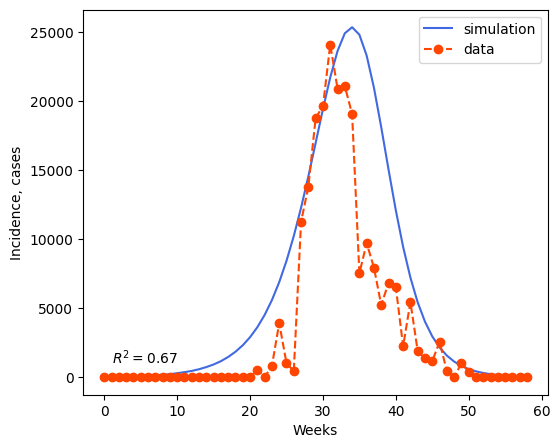

In [16]:
model.simulate(model_params=model_params, modeling_duration=size)
simulation_data = model.newly_infected

plot_calibration_result(simulation_data, prepared_data)

##### Age regime

In [14]:
data_df = epid_data.get_wave_data(regime='age')
prepared_data = epid_data.prepare_for_calibration()
init_infected = [100, 100]
model =  FactoryModel.age()

/Users/andrey/model_complex/model_complex/compartmental_models/epid_data/epid_data.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.returned_df['total_cases'] = self.returned_df.fillna(0)[['real_cases_strain_1',
/Users/andrey/model_complex/model_complex/compartmental_models/epid_data/epid_data.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.returned_df['sars_cases_age_group_0-2'] = self.returned_df.fillna(0)[['sars_cases_age_group_0',
/Users/andrey/model_complex/model_complex/compartmen

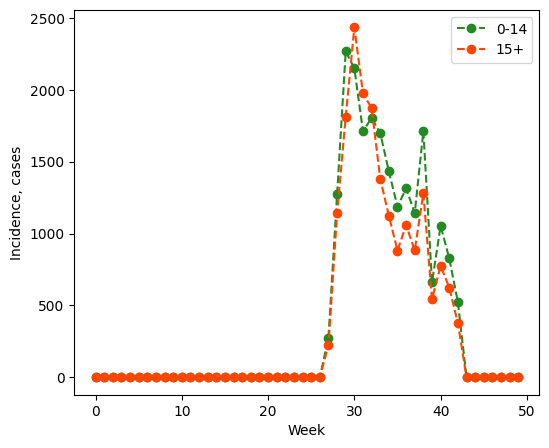

In [8]:
size = len(prepared_data)
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.set_xlabel('Week')
ax.set_ylabel('Incidence, cases')
ax.plot(prepared_data[0:size//2], "--o", color='forestgreen', label='0-14')
ax.plot(prepared_data[size//2:size], "--o", color='orangered', label='15+')
ax.legend()

In [9]:
rho = int(data_df['total_population'].iloc[0])
d = Calibration(init_infected, model, prepared_data, rho)
idata, data, simulation_func = d.abc_calibration()

Initializing SMC sampler...
Sampling 4 chains in 4 jobs
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


[0.25450743 0.29267021]
[0.89215013 0.88666379 0.80685153 0.62864591]


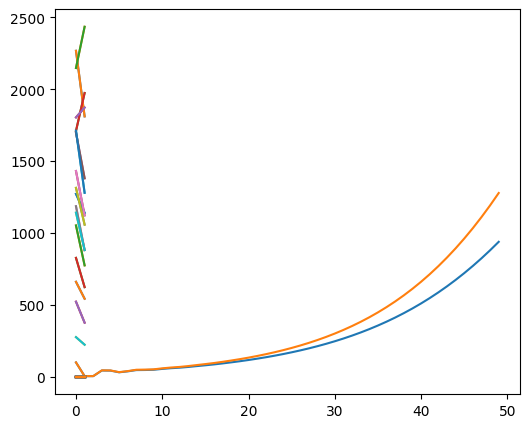

In [42]:
import numpy as np
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
start_day = 15    
posterior = idata.posterior.stack(samples=("draw", "chain"))
alpha_arr = np.array(posterior.alpha).mean(axis=1)
print(alpha_arr)

beta_arr = np.array(posterior.beta).mean(axis=1)
print(beta_arr)
model.simulate(alpha_arr, beta_arr, init_infected, rho, int(len(prepared_data)/model.alpha_len))
simulation_data = np.split(np.array(model.get_newly_infected()), model.alpha_len)
epid_data_incidence = np.split(prepared_data, model.alpha_len)
for sim, data in zip(simulation_data, epid_data_incidence):
    ax.plot(sim)
    ax.plot(epid_data_incidence)

In [40]:
epid_data_incidence[0]

array([   0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,  275.82747106,
       1272.10543767, 2268.019439  , 2148.62554301, 1710.51209351,
       1804.69883114, 1698.76828853, 1431.8614687 , 1186.64940489,
       1314.34832859, 1142.02336029, 1712.67008455,  660.91338583,
       1052.71205906,  827.26841641,  522.55922865,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ])

In [39]:
simulation_data[0]

array([100.        ,   4.3240781 ,   4.51098977,  43.62153499,
        42.86028057,  31.14547457,  37.80259365,  46.58496855,
        47.16519643,  48.7169172 ,  54.83922899,  59.68367833,
        63.21379282,  68.26143529,  74.24104265,  79.98406866,
        86.07122687,  92.98837308, 100.41520905, 108.25366109,
       116.74867622, 125.96501734, 135.84970367, 146.46781489,
       157.91938154, 170.24588707, 183.49117951, 197.73265362,
       213.04539802, 229.49547991, 247.15868439, 266.11958453,
       286.46283115, 308.27549329, 331.65053582, 356.68467725,
       383.47684673, 412.12903823, 442.74617778, 475.43488388,
       510.30272909, 547.4576706 , 587.00693126, 629.05561895,
       673.70532873, 721.052506  , 771.18647582, 824.18723843,
       880.12303232, 939.04760331])

### Pairwise model

In [5]:
pairwise_model = FactoryModel.pairwise(population_size=10**6, m_vertices=5)

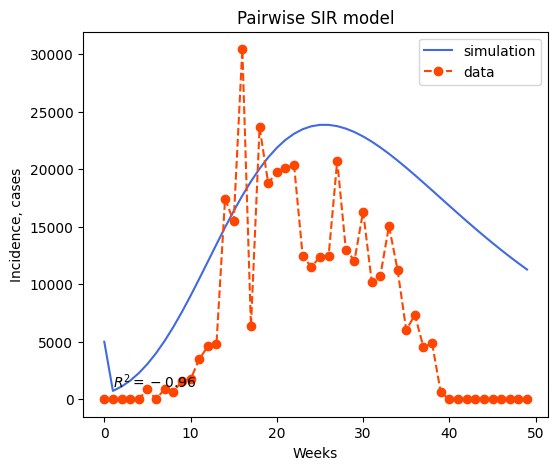

In [9]:
pairwise_model.simulate(tau=0.23, gamma=1/7, init_inf_frac=0.005, modeling_duration=len(prepared_data))
plot_calibration_result(pairwise_model.newly_infected, prepared_data, title='Pairwise SIR model')

Text(0, 0.5, 'Incidence')

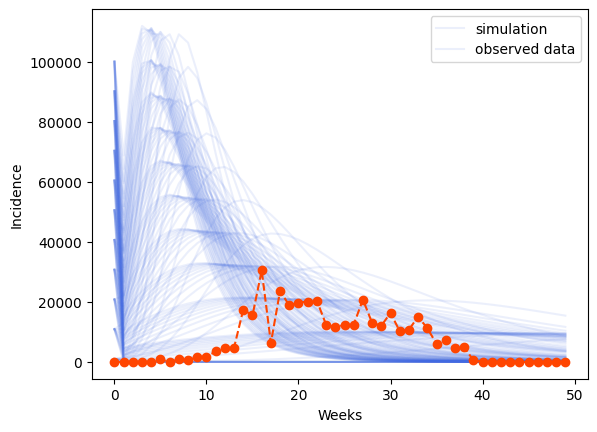

In [14]:
for tau in np.linspace(0, 1, 11):
    for init_inf_frac in np.linspace(0.001, 0.1, 11):
        pairwise_model.simulate(tau=tau, gamma=1/7, init_inf_frac=init_inf_frac, modeling_duration=len(prepared_data))
        plt.plot(pairwise_model.newly_infected, color='royalblue', alpha=0.1)
plt.plot(prepared_data, '--o', color='orangered')
plt.legend(['simulation', 'observed data'])
plt.xlabel('Weeks')
plt.ylabel('Incidence')

### Network model

In [22]:
network_model = FactoryModel.network(population_size=10**6, m_vertices=5)

In [28]:
from tqdm import tqdm

100%|██████████| 10/10 [00:20<00:00,  2.08s/it]


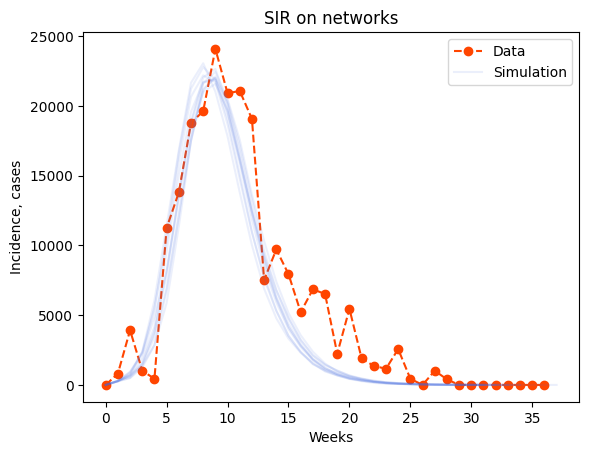

In [34]:
plt.plot(prepared_data, '--o', color='orangered')
for i in tqdm(range(10)):
    network_model.simulate(alpha=0.9, beta=0.085, initial_infectious=1, modeling_duration=len(prepared_data))
    plt.plot(network_model.newly_infected, color='royalblue', alpha=0.1)
plt.xlabel('Weeks')
plt.ylabel('Incidence, cases')
plt.title('SIR on networks')
plt.legend(['Data', 'Simulation'])
# plot_calibration_result(network_model.newly_infected, prepared_data, title='Network SIR model')

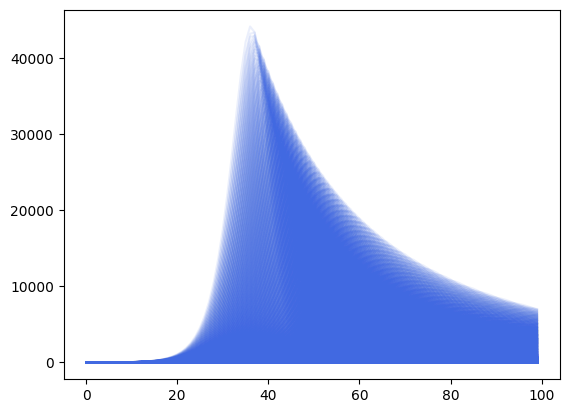

In [22]:
init_infected = [10]
alpha_arr = np.linspace(0.01, 0.99, 100)
beta_arr = np.linspace(0.01, 1, 100)
for alpha in alpha_arr:
    for beta in beta_arr:
        model.simulate([alpha], [beta], init_infected, 5*(10**5), 100)
        plt.plot(model.get_newly_infected(), color='royalblue', alpha=0.1)

In [35]:
import scipy

In [59]:
n_values = np.array([1, 2, 3])
p_values = np.array([0.1, 0.5, 0.9])  # Note: p must be between 0 and 1
n_grid, p_grid = np.meshgrid(n_values, p_values, indexing='ij')

n_flat = n_grid.flatten()
p_flat = p_grid.flatten()

sample_size = 1000  # Number of samples to generate
# samples = scipy.stats.nbinom.rvs(n_values, p_flat, size=(len(n_flat), sample_size))
samples = scipy.stats.nbinom.rvs(n=n_values.reshape(-1, 1), p=p_values.reshape(-1, 1), size=(len(n_values), 500))

TypeError: _parse_args_rvs() got an unexpected keyword argument 'mu'

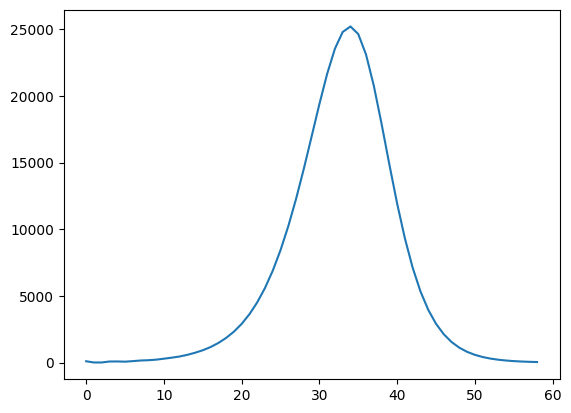

In [15]:
model.simulate(alpha=alpha_mean, beta=beta_mean, rho=5*10**5, initial_infectious=init_infected, modeling_duration=len(prepared_data))
plt.plot(model.get_newly_infected())
error_samples = model.get_resampled_data(alpha_estimated=alpha_mean[0], beta_estimated=beta_mean[0], observed_data=prepared_data)
for sample in error_samples:
    plt.plot(error_samples, color='red', alpha=0.005)
plt.ylim([0, 30000])
plt.plot(prepared_data, '--o')